# M.Sc. Course material on "Spectral Methods" October 2nd, 2025

This notebook is a part of exercises that complement the lecture. 

To make sure your environment is setup to perform the exercises please visit

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://github.com/apengsigkarup/SpectralMethods/

and follow the instructions for installing the environment.

If you have not already done so, please download all the files from this github repository and report any errors or issues with the materials to Allan Peter Engsig-Karup (apek@dtu.dk).

### Python modules needed

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import platform
import scipy
import time
import scipy.integrate


### Detect device

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Check for ARM architecture
architecture = platform.machine()
if 'arm' in architecture or 'aarch' in architecture:
    print("Architecture: ARM")
else:
    print(f"Architecture: {architecture}")

# Optional: More detailed GPU check
if device == "cuda":
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Check for CPU information
cpu_info = platform.processor()
if cpu_info:
    print(f"CPU: {cpu_info}")
else:
    print("CPU information not available.")


Device: cpu
Architecture: ARM
CPU: arm


### Define Precision used in PyTorch

In [3]:
# Set default tensor type in PyTorch to float64 precision
torch.set_default_dtype(torch.float64)

## Exercise 01: Fourier Series Approximation in 1D

The purpose of this notebook is two-fold
- utilize Fourier Series Approximations in 1D to approximate functions
- solve PDEs through spatial discretization with Fourier series and then solve initial value problems on periodic domains in 1D

### 1. Fourier Series Approximation in 1D

Approximate a function, and produce a convergence plot. Try with different functions (cf. define fun(x)), e.g. functions such as

$$
     f_1(x) = x
$$

and

$$
     f_2(x) = x(2\pi-x)
$$

or

$$
     f_3(x) = \frac{3}{5-4\cos(x)}
$$


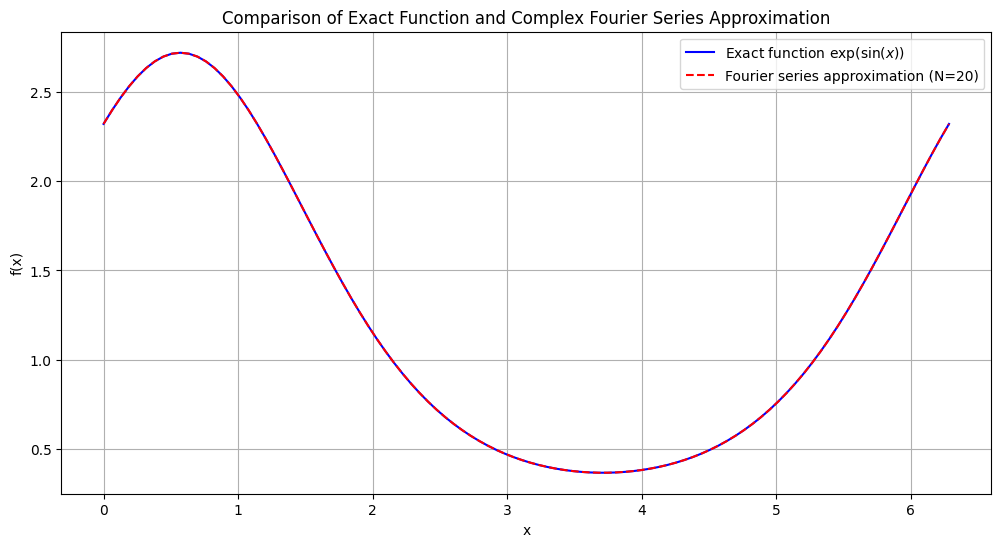

In [4]:
# Define the function fun(x) = exp(sin(x))
def fun(x):
    return np.exp(np.sin(x+1))

# Compute the Fourier coefficients using the composite trapezoidal rule
def compute_fourier_coefficients(a, b, N):
    x_nodes = np.linspace(a, b, N+1, endpoint=False)  # Equispaced grid points
    f_values = fun(x_nodes)
    
    # Interval length and dx
    dx = (b - a) / (N+1)
    #omega = 2 * np.pi / (b - a)
    
    # Compute Fourier coefficients
    c_n = np.zeros(N+1, dtype=complex)
    
    count = 0
    for n in range(-int(N/2), int(N/2)+1):
        exp_terms = np.exp(-1j * n * x_nodes)
        c_n[count] = (1 / (b - a)) * np.sum(f_values * exp_terms) * dx
        count = count + 1 

    return c_n 

# Complex Fourier series approximation
def complex_fourier_series(x, c_n):
    series = np.zeros_like(x, dtype=complex)
    N = len(c_n-1) 
    
    count = 0
    for n in range(-int(N/2), int(N/2)+1):
        series += c_n[count] * np.exp(1j * n * x)
        count = count + 1
    
    return series

# Interval [a, b]
a = 0
b = 2*np.pi

# Order of the Fourier series
N = 20  # Number of Fourier modes
# Compute Fourier coefficients
c_n  = compute_fourier_coefficients(a, b, N)

# Generate x values
x = np.linspace(a, b, 100)
y_exact = fun(x)
y_approx = complex_fourier_series(x, c_n).real

# Plot the exact function and its Fourier series approximation
plt.figure(figsize=(12, 6))
plt.plot(x, y_exact, label='Exact function $\exp(\sin(x))$', color='blue')
plt.plot(x, y_approx, label=f'Fourier series approximation (N={N})', color='red', linestyle='--')
plt.title('Comparison of Exact Function and Complex Fourier Series Approximation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


Evaluate the derivatives of a periodic function, and produce a verification plot and establish convergence of the method.

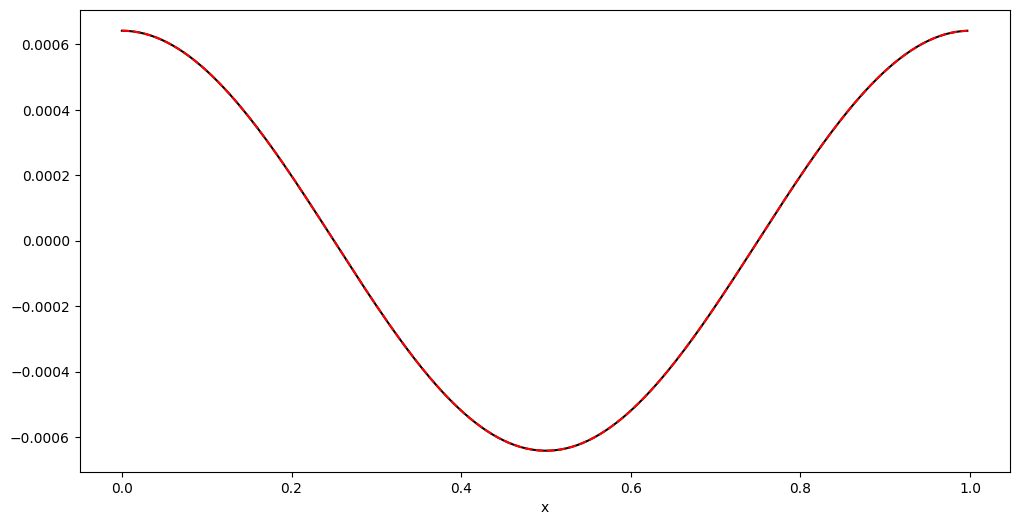

In [7]:
# Compute the first derive of a periodic function on a grid 0<=x<L
n  = 300 # number of modes
Lx = 1 #np.pi #np.pi # grid length
xs = np.linspace(0,Lx, num=n, endpoint=False)
u  = np.cos(2*np.pi*xs/Lx)
ua_x = -np.sin(2*np.pi*xs/Lx)/(2*np.pi/Lx) # analytical result
ua_xx = -np.cos(2*np.pi*xs/Lx)/(2*np.pi/Lx)**2 # analytical result
ua_xxxx = np.cos(2*np.pi*xs/Lx)/(2*np.pi/Lx)**4 # analytical result

# wave number, fourier modes
kappa = np.arange(-n/2,n/2)
kappa = np.fft.fftshift(kappa)/(2*np.pi/Lx)

# compute derivative
u_hat = np.fft.fft(u)
u_x_hat = (1j*kappa)*u_hat
u_xx_hat    = ((1j*kappa)**2)*u_hat
u_xxxx_hat  = ((1j*kappa)**4)*u_hat

u_x     = np.real(np.fft.ifft(u_x_hat))
u_xx    = np.real(np.fft.ifft(u_xx_hat))
u_xxxx  = np.real(np.fft.ifft(u_xxxx_hat))

fig = plt.figure(figsize=(12, 6))
plt.plot(xs,ua_xxxx,'k')
plt.plot(xs,u_xxxx,'r--')
plt.xlabel('x')
plt.show()

### 2. Solve the general initial value problem for PDEs

Discretize using the Method of Lines, where spatial discretization is performed using a Fourier Series in space and a finite difference based temporal integration is performed to solve the initial value problems.

### Burger's equation in 1D

Consider the viscous Burger’s equation in 1D that is a time-dependent nonlinear advection-diffusion equation. 

$$
    \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial (u^2)}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2}
$$

where $u(x, t)$ is unknown function to find subject to the conditions:
- $u(-1, t) = 0$ and $u(1, t) = 0$ (Homogeneous boundary conditions)
- $u(x, 0) = -\sin(\pi x)$ (Initial condition)
- $\epsilon = 0.01/\pi$ (Diffusion coefficient)

The goal is to solve this equation on the domain $x \in [-1, 1], t > 0$, and estimate the value $\partial u/\partial x|_{x=0}=-152.00516$ (ground truth) at time $t=1.6037/\pi$.

Challenge yourself: how accurate can you get the estimate of the gradient at $x=0$ at the final time $t=1.6037/\pi$? 

50
Execution time: 0.0355 seconds
100
Execution time: 0.0280 seconds
200
Execution time: 0.0396 seconds
400
Execution time: 0.0724 seconds
800
Execution time: 0.2056 seconds
1600
Execution time: 1.1757 seconds
2000
Execution time: 2.1750 seconds


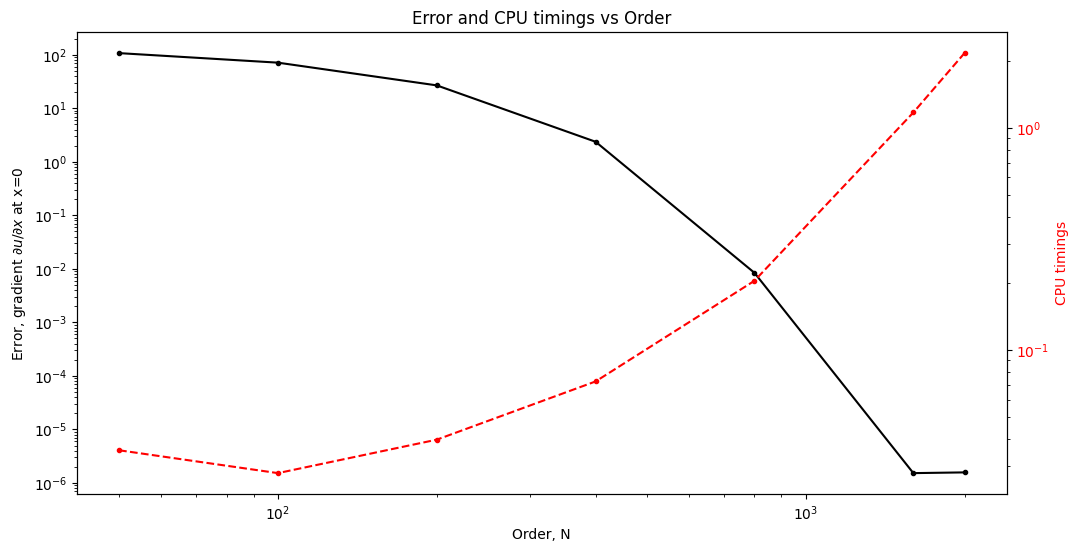

<Figure size 800x600 with 0 Axes>

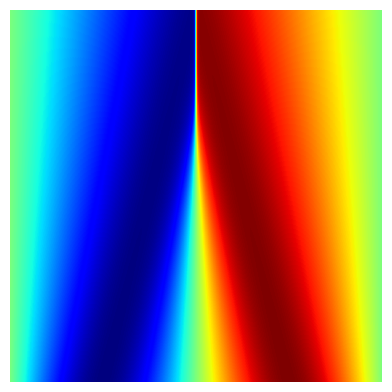

Estimated gradient at x=0 at t=0.51047: -152.00516
True gradient at x=0 at t=0.51047: -152.00516


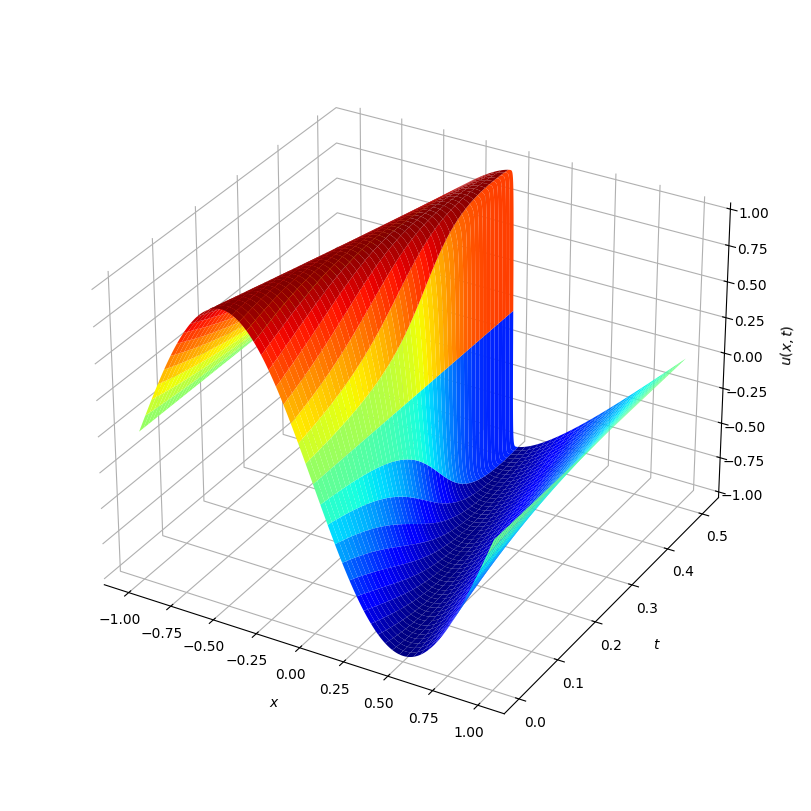

<Figure size 1200x600 with 0 Axes>

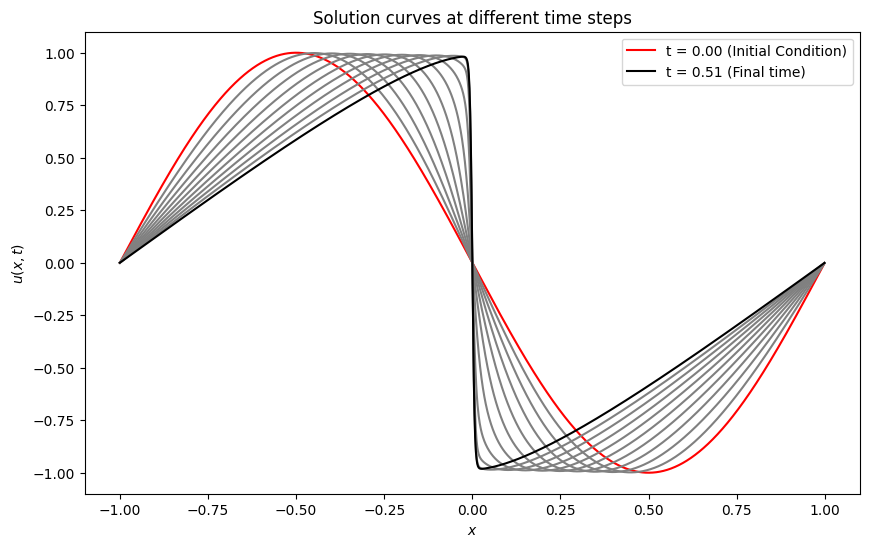

In [ ]:
# Problem parameters
t_final = 1.6037 / np.pi
true_gradient_at_0 = -152.00516

# Define PDE to be solved
def rhs_burgers(t,u,kappa):
    u_hat = np.fft.fft(u)    
    u_x_hat     = (1j*kappa)*u_hat
    u_xx_hat    = ((1j*kappa)**2)*u_hat
    u_x     = np.real(np.fft.ifft(u_x_hat))
    u_xx    = np.real(np.fft.ifft(u_xx_hat))
    return -u*u_x + (0.01/np.pi)*u_xx 

def solve_pde(rhs,n):
    Lx = 2 
    xs = np.linspace(-Lx/2,Lx/2, num=n, endpoint=False)
    u0 = -np.sin(np.pi*xs)

    kappa = np.arange(-n/2,n/2)
    kappa = np.fft.fftshift(kappa)*(2*np.pi/Lx)

    # Define uniformly spaced time points
    num_time_points = n  # Specify the number of time points you want
    t_eval = np.linspace(0, t_final, num_time_points)

    # Integrate the PDE
    start_time = time.time()
    sol = scipy.integrate.solve_ivp(rhs, t_span=(0, t_final), y0=u0, args=(kappa,), t_eval=t_eval, atol=1e-12, rtol=1e-12)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")
    t_cord = sol.t
    y_cord = sol.y
    return t_cord, y_cord, kappa, xs, execution_time

# Convergence test
errorGradient = []
CPUtimes = []
nL = [50, 100, 200, 400, 800, 1600, 2000]
for n in nL:
    print(n)
    t_cord, y_cord, kappa, xs, execution_time = solve_pde(rhs_burgers,n)

    # Compute the gradient at x=0
    # At x=0, the gradient is simply the sum of Fourier modes weighted by their wavenumbers
    u_final_at_t = y_cord[:, -1]  # Solution at final time
    u_final_fft = np.fft.fft(u_final_at_t)
    u_x_hat = (1j * kappa) * u_final_fft
    u_x_final = np.real(np.fft.ifft(u_x_hat))
    gradient_at_0 = u_x_final[np.argmin(np.abs(xs))]  # Find the value closest to x=0
    errorGradient.append(np.abs(gradient_at_0 - true_gradient_at_0))
    CPUtimes.append(execution_time)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the error gradient
ax1.loglog(nL, errorGradient, 'k.-')
ax1.set_xlabel('Order, N')
ax1.set_ylabel('Error, gradient $\partial u/\partial x$ at x=0', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second y-axis for the CPU timings
ax2 = ax1.twinx()
ax2.loglog(nL, CPUtimes, 'r.--')
ax2.set_ylabel('CPU timings', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Error and CPU timings vs Order')
plt.show()

# Generate the 'jet' colormap with 100 colors
cmap = plt.get_cmap('jet', 300)
colors = cmap(np.arange(cmap.N))  # Get colors from the colormap

fig = plt.figure(figsize=(8, 6))
plt.matshow(y_cord[-1::-1,-1::-1].T, cmap=cmap)
plt.axis('off')  # Remove axes
plt.show()

# Compute the gradient at x=0
# At x=0, the gradient is simply the sum of Fourier modes weighted by their wavenumbers
u_final_at_t = y_cord[:, -1]  # Solution at final time
u_final_fft = np.fft.fft(u_final_at_t)
u_x_hat = (1j * kappa) * u_final_fft
u_x_final = np.real(np.fft.ifft(u_x_hat))
gradient_at_0 = u_x_final[np.argmin(np.abs(xs))]  # Find the value closest to x=0

# Print the estimated gradient at x=0
print(f"Estimated gradient at x=0 at t={t_final:.5f}: {gradient_at_0:.5f}")
print(f"True gradient at x=0 at t={t_final:.5f}: {true_gradient_at_0:.5f}")

# Create a meshgrid for the solution
T, X = np.meshgrid(t_cord, xs)

# Plotting the mesh plot
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, T, y_cord, cmap=cmap)

ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u(x,t)$')
#ax.set_title('Mesh plot of the solution u(x,t)')
ax.set_box_aspect(aspect=None, zoom=0.9)
# Manually adjust the position of the z-label
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
# Set background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
# Set the background color of the 3D axis
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

plt.show()

fig = plt.figure(figsize=(12, 6))
# Plot solution curves for every 100th time step
plt.figure(figsize=(10, 6))
plt.plot(xs,y_cord[:, 0], label=f't = {t_cord[0]:.2f} (Initial Condition)', color='red')
for i in range(0, len(t_cord)-1, 200):
    if i>0:
        plt.plot(xs,y_cord[:, i], color='grey')
# Ensure the first and last time steps are included
plt.plot(xs,y_cord[:, -1], label=f't = {t_cord[-1]:.2f} (Final time)', color='black')

plt.xlabel('$x$')
plt.ylabel('$u(x,t)$')
plt.title('Solution curves at different time steps')
plt.legend()
plt.show()



<Figure size 1200x600 with 0 Axes>

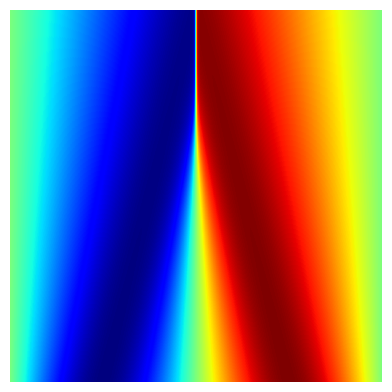

In [10]:
fig = plt.figure(figsize=(12, 6))
#plt.matshow(y_cord_2[-1::-1,-1::-1].T, cmap='viridis')
plt.matshow(y_cord[-1::-1,-1::-1].T, cmap=cmap)
plt.axis('off')  # Remove axes
plt.show()

Store the data for other experiments.

In [11]:
filename = 'Burgers1D_Fourier.npz'

# Save arrays to a file
np.savez(filename, xs=xs, t_cord=t_cord, y_cord=y_cord)

# Define the relative path
dirpath = '' # "../../../Data/CYLINDER_ALL.mat"
relative_path = dirpath + filename 

# Convert to absolute path
absolute_path = os.path.abspath(relative_path)

# Print the absolute path (optional)
print(f"Absolute path:\n {absolute_path}\n")

# Load arrays from the file
data = np.load('Burgers1D_Fourier.npz')
xs = data['xs']
t_cord = data['t_cord']
y_cord = data['y_cord']

Absolute path:
 /Users/apek/Dropbox/Latex/Teaching/02901 PhD school - Advanced Machine Learning/Materials/Code/Solutions/Exercise 03 Numerical Discretization/Burgers1D_Fourier.npz



Perform a convergence test that demonstrates spectral convergence.

/var/folders/5k/2v1vg4xx0mzdmzsh6vqs6pwh0000gp/T/ipykernel_15030/1214950818.py:50: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, np.max(N_list), 1e-15, 1e3])


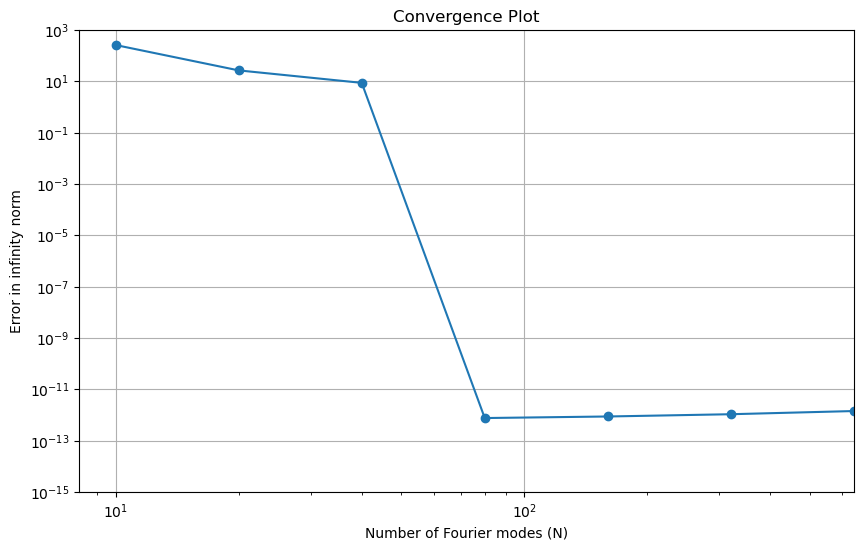

In [27]:
# Parameters
Lx = 2
t_final = 1.6037 / np.pi
epsilon = 0.01 / np.pi
N_list = [10, 20, 30, 50, 60, 70, 80, 90, 100,110, 120, 130, 140,160, 240, 480]  # Different values of N for convergence study
N_list = [10, 20, 40, 80, 160, 320, 640]
errors = []

def rhs_burgers(t, u, kappa):
    u_hat = np.fft.fft(u)
    u_x_hat = (1j * kappa) * u_hat
    u_xx_hat = ((1j * kappa) ** 2) * u_hat

    u_x = np.real(np.fft.ifft(u_x_hat))
    u_xx = np.real(np.fft.ifft(u_xx_hat))

    return -u * u_x + epsilon * u_xx

# Reference solution with a high resolution
def compute_solution(N):
    n = 2 * N
    xs = np.linspace(-Lx/2, Lx/2, num=n, endpoint=False)
    kappa = np.fft.fftshift(np.fft.fftfreq(n, d=Lx/n) * 2 * np.pi)

    u0 = -np.sin(np.pi * xs)
    t_eval = np.linspace(0, t_final, num=100)

    sol = scipy.integrate.solve_ivp(rhs_burgers, t_span=(0, t_final), y0=u0, args=(kappa,), t_eval=t_eval, method='RK45', atol=1e-12, rtol=1e-12)
    return sol.t, sol.y, xs

# Compute a reference solution at very fine grid
t_ref, y_ref, xs_ref = compute_solution(2*N_list[-1])

# Calculate error for each N
for N in N_list:
    t, y, xs = compute_solution(N)
    # Interpolate the solution to the reference grid
    y_interp = np.interp(xs_ref, np.linspace(-Lx/2, Lx/2, num=2*N, endpoint=False), y[:, -1])
    # Calculate the error in infinity norm
    error = np.max(np.abs(y_ref[:, -1] - y_interp))
    errors.append(error)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.loglog(N_list, errors, 'o-', base=10)
plt.xlabel('Number of Fourier modes (N)')
plt.ylabel('Error in infinity norm')
plt.title('Convergence Plot')
plt.grid(True)
plt.axis([0, np.max(N_list), 1e-15, 1e3])
plt.show()
